# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve

# Read in model

In [2]:
expected_model_version = 1.0

model_path = '../models/best_model.pickle'

if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

# Model Parameters

In [3]:
model.get_params()

{'memory': None,
 'steps': [('simpleimputer', SimpleImputer(strategy='median')),
  ('standardscaler', None),
  ('adaboostclassifier',
   AdaBoostClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.01, max_depth=4,
                                                       max_features='log2',
                                                       min_impurity_decrease=0.0001,
                                                       min_samples_leaf=5,
                                                       min_samples_split=4),
                      learning_rate=0.01, n_estimators=300))],
 'verbose': False,
 'simpleimputer': SimpleImputer(strategy='median'),
 'standardscaler': None,
 'adaboostclassifier': AdaBoostClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.01, max_depth=4,
                                                     max_features='log2',
                                                     min_impurity_decrease=0.0001,
                                                 

# Read in data

In [4]:
data_path = '../data/processed/test_data.pickle'
if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
else:
    print("Expected data not found")

In [5]:
X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

# Classification report

In [6]:
y_predict = model.predict(X_test)
classification_report_dict = classification_report(y_test, y_predict, output_dict=True)
classification_report_df = pd.DataFrame(dict(itertools.islice(classification_report_dict.items(), 2))).T
classification_report_df = classification_report_df[['precision', 'recall', 'f1-score']]
long_df = classification_report_df.reset_index().melt(id_vars='index')
long_df.columns = ['Has Heart Disease', 'Metric', 'Value']
long_df['Has Heart Disease'] = np.where(long_df['Has Heart Disease']=='1', 'heart disease', 'no heart disease')

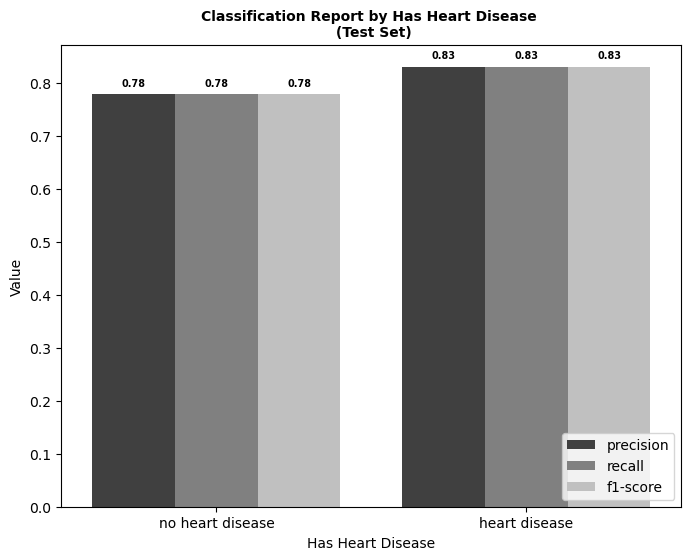

In [7]:
plt.figure(figsize=(8, 6))

bar_plot = sns.barplot(x='Has Heart Disease', y='Value', hue='Metric', data=long_df, palette='gray')

for bar in bar_plot.patches:
    bar_plot.annotate(format(bar.get_height(), '.2f'),
                      (bar.get_x() + bar.get_width() / 2,
                       bar.get_height()), ha='center', va='center',
                       fontsize='x-small', xytext=(0, 8),
                       textcoords='offset points', fontweight='bold')

plt.title('Classification Report by Has Heart Disease \n (Test Set)', fontsize=10, fontweight='bold')
plt.xlabel('Has Heart Disease')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.show()

# ROC curve

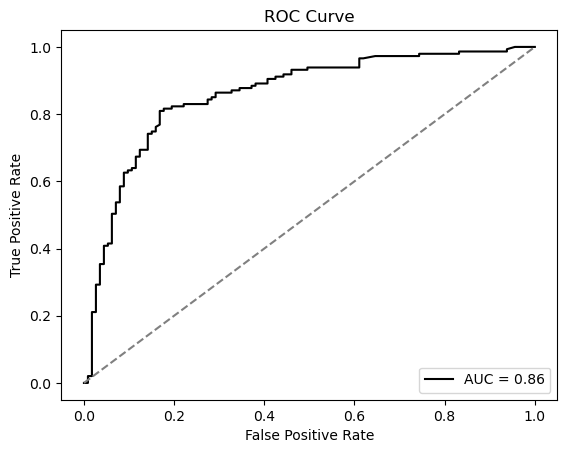

In [8]:
y_pred_proba = model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, color='black', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion matrices

In [9]:
def get_confusion_matrix(normalize):
    cm = confusion_matrix(y_test, y_predict, labels = model.classes_)
    display_cm = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                        display_labels = ['no heart disease', 'heart disease'], 
                                                       normalize=normalize, cmap='gray')

### Counts

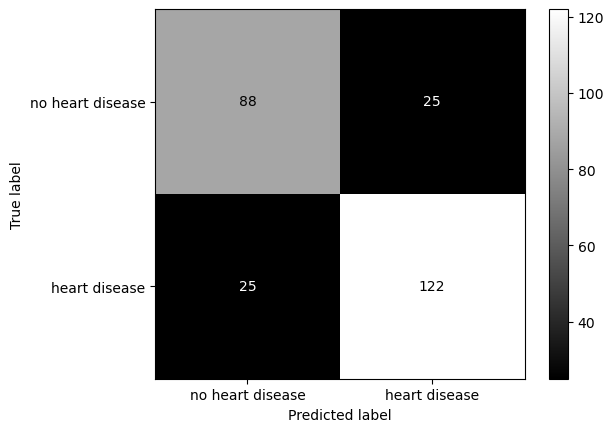

In [10]:
get_confusion_matrix(normalize=None)

### Ratios

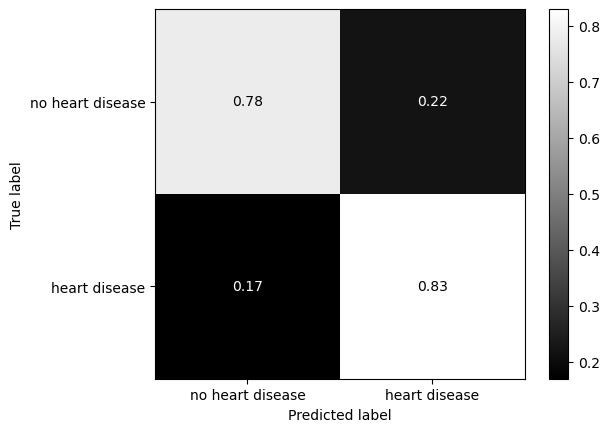

In [11]:
get_confusion_matrix(normalize='true')

# Analysis of predicted probabilities vs. correct classification

In [12]:
y_predict_proba = model.predict_proba(X_test)
probabilities = pd.DataFrame(y_predict_proba, columns=[model.classes_]).merge(y_test.reset_index(drop=True), 
                                                                              left_index=True, 
                                                                              right_index=True).merge(pd.DataFrame(y_predict), left_index=True,
                                                                                                     right_index=True)
probabilities.columns = ['No', 'Yes', 'Has Heart Disease', 'Heart Disease Prediction']
probabilities['Predicted Class Probability'] = np.where(probabilities['Heart Disease Prediction'] == 1, probabilities['Yes'], probabilities['No'])
probabilities['Correct Classification'] = np.where(probabilities['Has Heart Disease']==probabilities['Heart Disease Prediction'], 'Yes', 'No')
probabilities['Has Heart Disease'] = np.where(probabilities['Has Heart Disease']==1, 'heart disease', 'no heart disease')
bins = [0.5, 0.55, 0.65, 0.75]
labels = ['0.5-0.55', '0.55-0.65', '0.65-0.75']
probabilities['Predicted Class - Probability Bin'] = pd.cut(probabilities['Predicted Class Probability'], bins=bins, labels=labels, include_lowest=True, right=False)
probabilities = probabilities[['Has Heart Disease', 'Correct Classification','Predicted Class Probability','Predicted Class - Probability Bin']]
grouped = probabilities.groupby(['Predicted Class - Probability Bin', 'Has Heart Disease', 'Correct Classification']).size().unstack(fill_value=0)
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0)

In [13]:
def add_labels_percentages(ax):
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        if height !=0:
            x, y = p.get_xy() 
            ax.text(x + width/2, 
                    y + height/2, 
                    f'{height:.0%}', 
                    horizontalalignment='center', 
                    verticalalignment='center',
                   fontweight='bold')
            
def add_labels_counts(ax):
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        if height !=0:
            x, y = p.get_xy() 
            ax.text(x + width/2, 
                    y + height/2, 
                    f'{int(height)}', 
                    horizontalalignment='center', 
                    verticalalignment='center',
                   fontweight='bold')

### Has heart disease

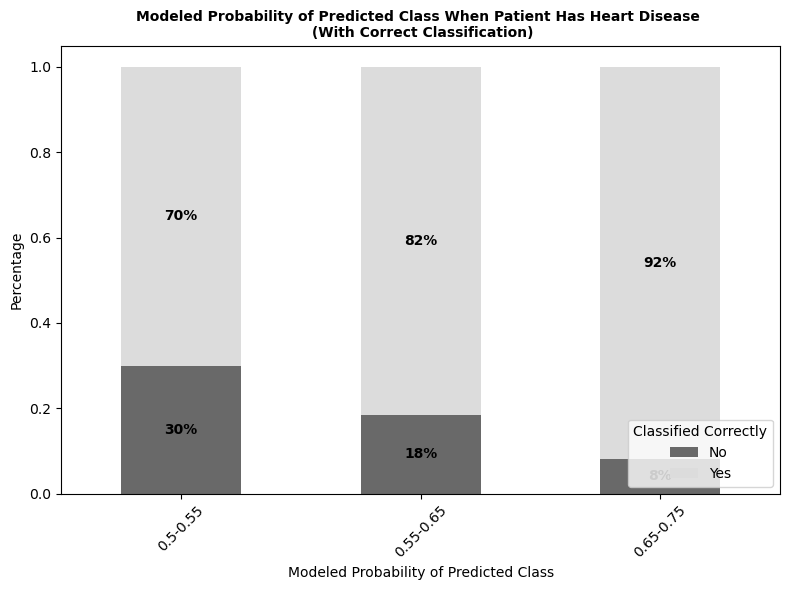

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey=True)

grouped_percentage.xs('heart disease', level='Has Heart Disease').plot(kind='bar', stacked=True, ax=ax, color=['dimgrey', 'gainsboro'])
ax.set_title('Modeled Probability of Predicted Class When Patient Has Heart Disease \n (With Correct Classification)', 
             fontsize=10, fontweight='bold')
ax.set_xlabel("Modeled Probability of Predicted Class")
ax.set_ylabel('Percentage')
ax.legend(loc='lower right', title='Classified Correctly')
ax.tick_params(axis='x', rotation=45)

add_labels_percentages(ax)

plt.tight_layout()
plt.show()

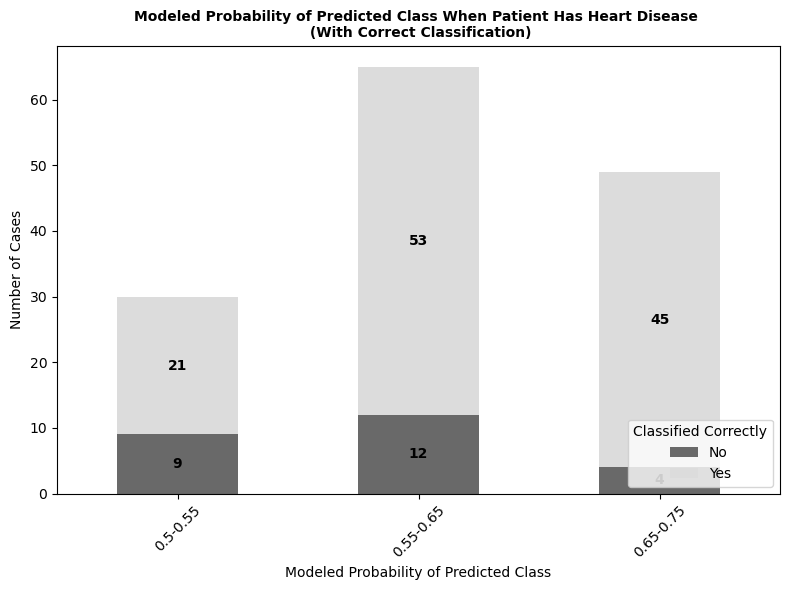

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey=True)

grouped.xs('heart disease', level='Has Heart Disease').plot(kind='bar', stacked=True, color=['dimgrey', 'gainsboro'], ax=ax)
ax.set_title('Modeled Probability of Predicted Class When Patient Has Heart Disease \n (With Correct Classification)', 
             fontsize=10, fontweight='bold')
ax.set_xlabel("Modeled Probability of Predicted Class")
ax.set_ylabel('Number of Cases')
ax.legend(loc='lower right', title='Classified Correctly')
ax.tick_params(axis='x', rotation=45)

add_labels_counts(ax)

plt.tight_layout()
plt.show()

### Does not have heart disease

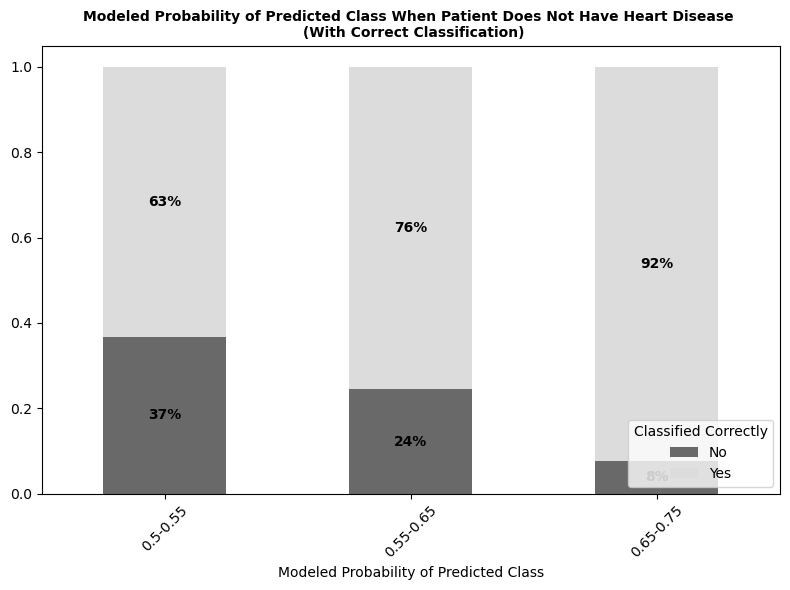

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey=True)

grouped_percentage.xs('no heart disease', level='Has Heart Disease').plot(kind='bar', stacked=True, ax=ax, color=['dimgrey', 'gainsboro'])
ax.set_title('Modeled Probability of Predicted Class When Patient Does Not Have Heart Disease \n (With Correct Classification)',
            fontsize=10, fontweight='bold')
ax.set_xlabel('Modeled Probability of Predicted Class')
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='lower right', title='Classified Correctly')

add_labels_percentages(ax)

plt.tight_layout()
plt.show()

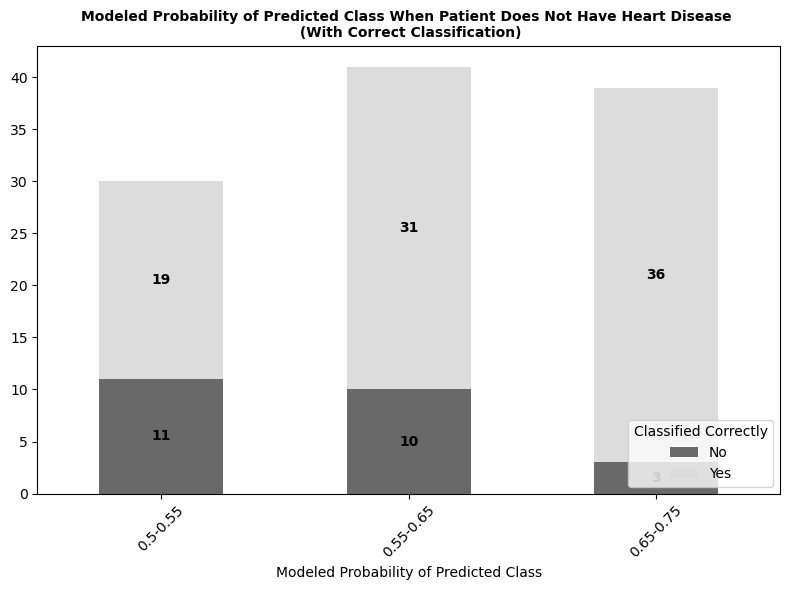

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey=True)

grouped.xs('no heart disease', level='Has Heart Disease').plot(kind='bar', stacked=True, ax=ax, color=['dimgrey', 'gainsboro'])
ax.set_title('Modeled Probability of Predicted Class When Patient Does Not Have Heart Disease \n (With Correct Classification)',
            fontsize=10, fontweight='bold')
ax.set_xlabel('Modeled Probability of Predicted Class')
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='lower right', title='Classified Correctly')

add_labels_counts(ax)

plt.tight_layout()
plt.show()

# Feature importances

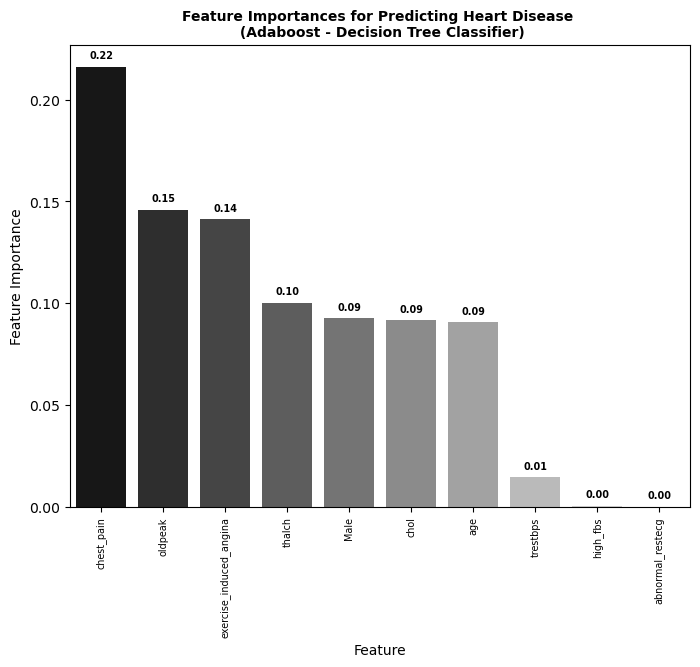

In [18]:
features = model[:-1].get_feature_names_out()
feature_importances = model.named_steps.adaboostclassifier.feature_importances_
feature_importances = pd.Series(feature_importances, index=features).sort_values(ascending=False)

feature_importances = feature_importances.reset_index()
feature_importances.columns = ['Feature', 'Feature Importance']

plt.figure(figsize=(8, 6))

bar_plot = sns.barplot(x='Feature', y='Feature Importance', data=feature_importances, palette='gist_gray')

for bar in bar_plot.patches:
    bar_plot.annotate(format(bar.get_height(), '.2f'),
                      (bar.get_x() + bar.get_width() / 2,
                       bar.get_height()), ha='center', va='center',
                       fontsize='x-small', xytext=(0, 8),
                       textcoords='offset points', fontweight='bold')
_ = plt.title('Feature Importances for Predicting Heart Disease \n (Adaboost - Decision Tree Classifier)', 
              fontsize=10, fontweight='bold')
_ = plt.xlabel('Feature')
_ = plt.xticks(rotation=90, fontsize='x-small')
_ = plt.ylabel('Feature Importance')

# Additional graphics for final report

In [19]:
data = pd.concat([X_train, X_test]).merge(pd.concat([y_train, y_test]), left_index=True, right_index=True)

### Boxplots

In [20]:
def get_boxplots(dataset, col_names, num_boxplot_cols):
    df = dataset.melt(id_vars='num', value_vars=col_names)
    g = sns.catplot(
        data=df, 
        y='value', 
        x='variable', 
        hue='num', 
        kind='box', 
        col_wrap=num_boxplot_cols, 
        col='variable', 
        sharex=False,
        sharey=False,
        legend=False,
        palette='gray')
    g.set_titles('{col_name}')
    g.tight_layout()
    plt.legend(title='Has Heart Disease', loc='upper right')

Heart Disease vs. No Heart Disease


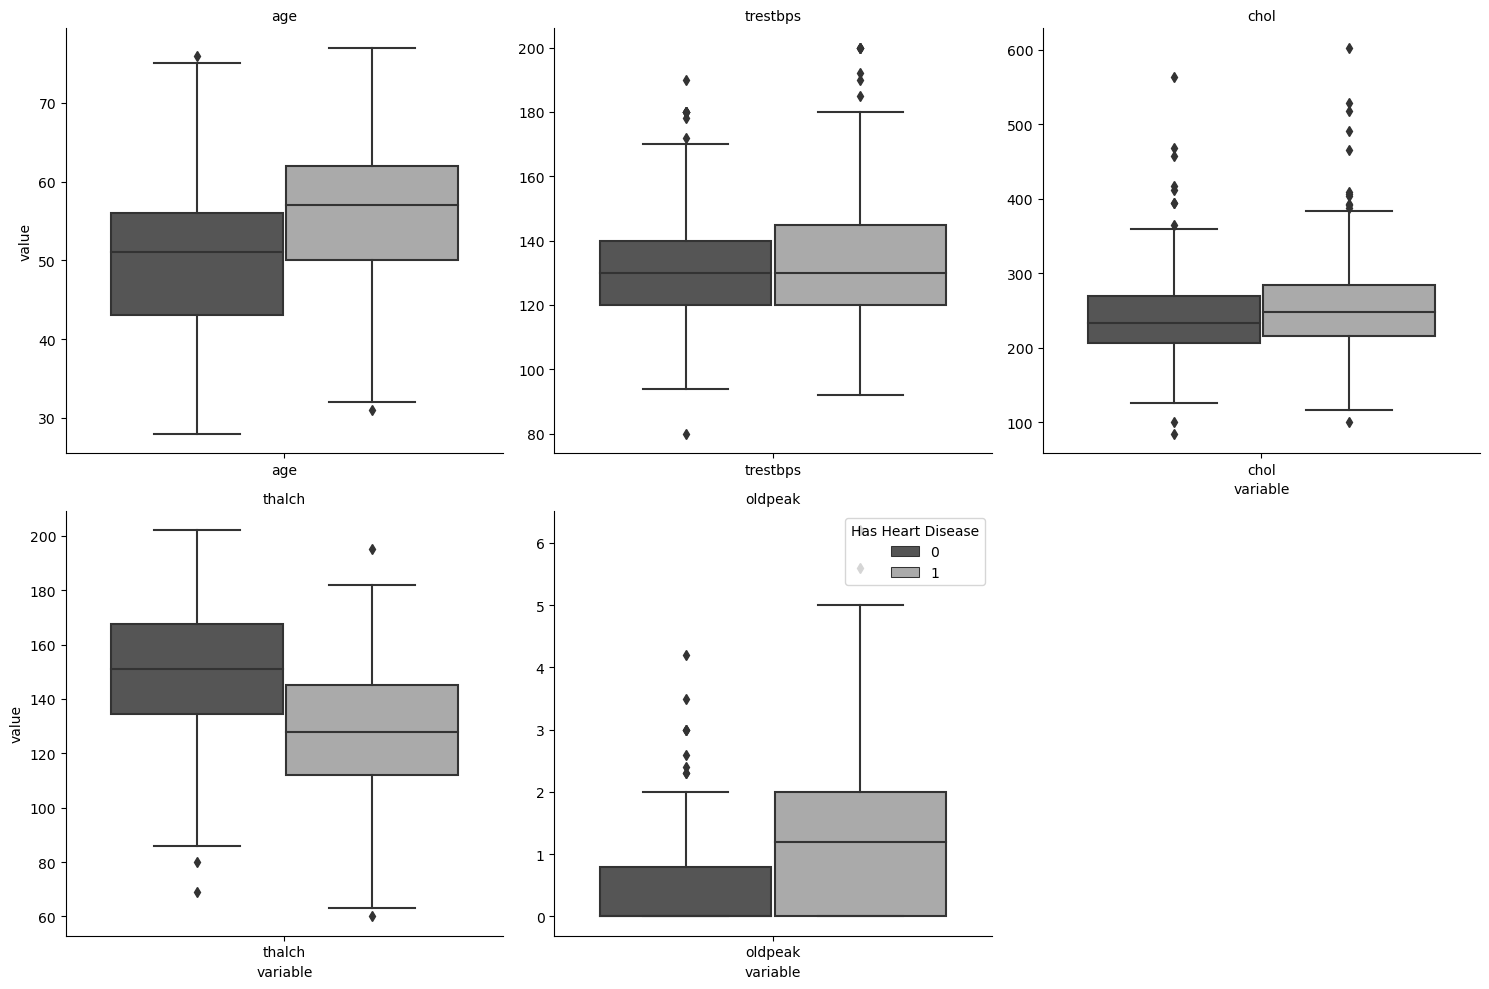

In [21]:
cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
print('Heart Disease vs. No Heart Disease')
get_boxplots(data, cols, 3)

### Stacked barcharts

In [22]:
def get_stacked_barcharts(dataset, columns):
    plt.figure(figsize=(10, 8))
    for i, col in enumerate(columns, start=1):
        plt.subplot(3, 3, i)
        counts = dataset.groupby('num')[col].value_counts().unstack().T
        percentages = counts.div(counts.sum(axis=0), axis=1) * 100
        ax = percentages.T.plot(kind='bar', stacked=True, ax=plt.gca(), color=['gray', 'lightgray'], legend=False)
        # Set the title and labels
        plt.title(f'{col} by Heart Disease (1) or No Heart Disease (0)', fontsize=6)
        plt.xlabel('')
        plt.ylabel('Percentage')
        if i==3:
            ax.legend(loc='lower right', title='1 = Yes, 0 = No')
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center', fontweight='bold')
    # Adjust the layout
    plt.tight_layout()

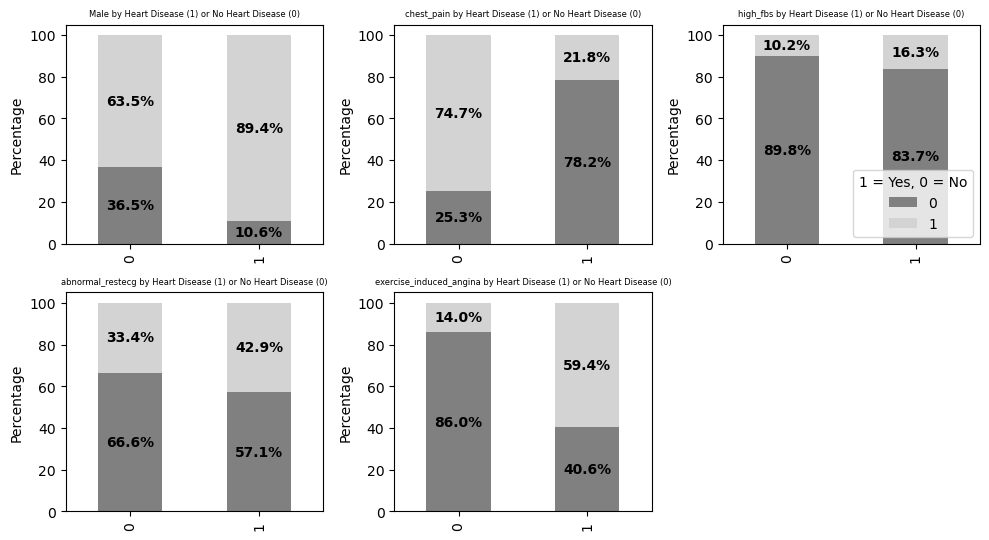

In [23]:
get_stacked_barcharts(data, ['Male', 'chest_pain', 'high_fbs', 'abnormal_restecg', 'exercise_induced_angina'])

### Heatmap

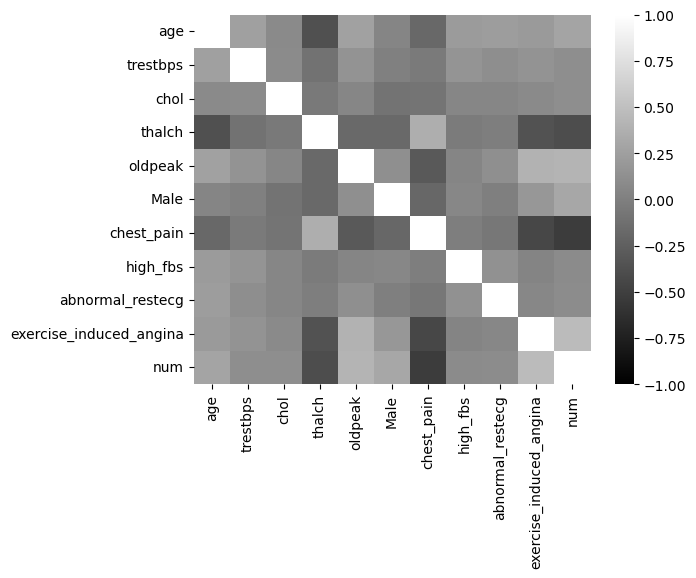

In [24]:
sns.heatmap(data[['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'Male', 'chest_pain', 
                         'high_fbs', 'abnormal_restecg', 'exercise_induced_angina', 'num']].corr(), 
            vmin=-1, vmax=1,cmap='gray');

### Correlation coefficients

In [25]:
def get_correlation_coefficient(dataset, var):
    df = dataset[[var, 'num']]
    df = df.dropna()
    correlation_coeff = df[var].corr(df['num'])
    print(f'Correlation coefficient - {var} and num: {correlation_coeff:.2}')

In [26]:
print('Correlation Coefficients:')
for var in ['exercise_induced_angina', 'oldpeak', 'Male', 'age', 'trestbps', 'chol', 'abnormal_restecg', 'high_fbs',
            'thalch', 'chest_pain']:
    get_correlation_coefficient(data, var)

Correlation Coefficients:
Correlation coefficient - exercise_induced_angina and num: 0.46
Correlation coefficient - oldpeak and num: 0.41
Correlation coefficient - Male and num: 0.31
Correlation coefficient - age and num: 0.29
Correlation coefficient - trestbps and num: 0.12
Correlation coefficient - chol and num: 0.11
Correlation coefficient - abnormal_restecg and num: 0.097
Correlation coefficient - high_fbs and num: 0.088
Correlation coefficient - thalch and num: -0.39
Correlation coefficient - chest_pain and num: -0.53
